# Mock QA

This notebook visualizes the default set of mocks currently (as of 2018 Feb) being used in the DESI Data Challenges.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set(style='white', font_scale=1.1, palette='Set2')

#### Dark-time targets: QSOs (tracer & Lya), LRGs, and ELGs
(Note that there's a bug in the Lya densities that needs to be tracked down.)

In [3]:
from desitarget.mock.mockmaker import QSOMaker, LYAMaker, LRGMaker, ELGMaker

INFO:mockmaker.py:627:readmock: Reading the whole DESI footprint with nside = 16.
INFO:mockmaker.py:638:readmock: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.7_2LPT/QSO.fits
INFO:mockmaker.py:643:readmock: Assigning healpix pixels with nside = 16.
INFO:mockmaker.py:655:readmock: Trimmed to 3739643 QSOs in 1269 healpixel(s).


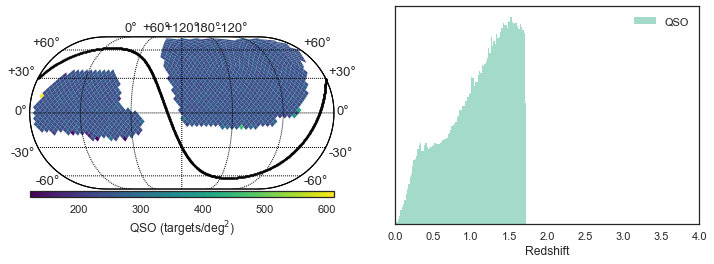

INFO:mockmaker.py:1099:readmock: Reading the whole DESI footprint with nside = 16.
INFO:mockmaker.py:1110:readmock: Reading /Users/ioannis/work/desi/mocks/lya_forest/v2.0.2/master.fits
INFO:mockmaker.py:1123:readmock: Assigning healpix pixels with nside = 16
INFO:mockmaker.py:1135:readmock: Trimmed to 2209348 LYAs in 1269 healpixel(s).


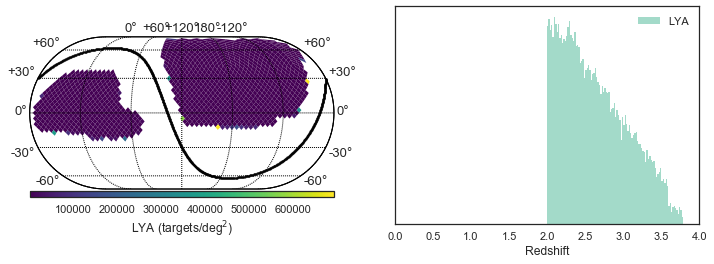

INFO:io.py:1025:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.5/lrg_templates_v2.0.fits
INFO:mockmaker.py:627:readmock: Reading the whole DESI footprint with nside = 16.
INFO:mockmaker.py:638:readmock: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.7_2LPT/LRG.fits
INFO:mockmaker.py:643:readmock: Assigning healpix pixels with nside = 16.
INFO:mockmaker.py:655:readmock: Trimmed to 14230581 LRGs in 1269 healpixel(s).


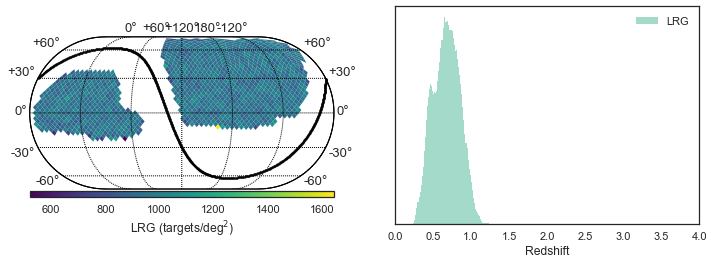

INFO:io.py:1025:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.5/elg_templates_v2.0.fits
INFO:mockmaker.py:627:readmock: Reading the whole DESI footprint with nside = 16.
INFO:mockmaker.py:638:readmock: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.7_2LPT/ELG.fits
INFO:mockmaker.py:643:readmock: Assigning healpix pixels with nside = 16.
INFO:mockmaker.py:655:readmock: Trimmed to 72019558 ELGs in 1269 healpixel(s).


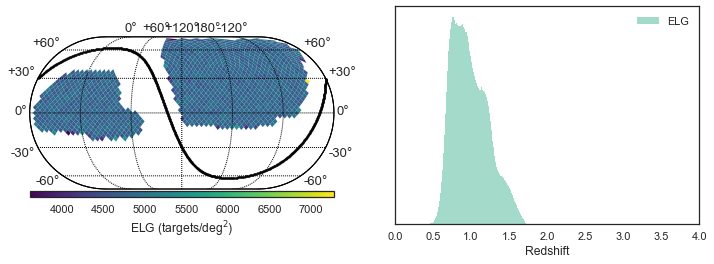

In [4]:
for Maker in (QSOMaker, LYAMaker, LRGMaker, ELGMaker):
    M = Maker()
    data = M.read()
    M.qamock_sky(data)

#### Bright-time extragalactic targets: BGS

In [5]:
from desitarget.mock.mockmaker import BGSMaker

INFO:io.py:1025:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits
INFO:mockmaker.py:1239:readmock: Reading the whole DESI footprint with nside = 16.
INFO:mockmaker.py:1260:readmock: Assigning healpix pixels with nside = 16
INFO:mockmaker.py:1272:readmock: Trimmed to 41561531 BGSs in 1269 healpixel(s).


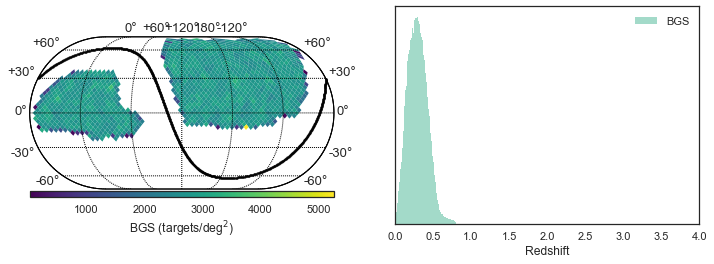

In [6]:
M = BGSMaker()
data = M.read()
M.qamock_sky(data)

#### Bright-time stellar targets: MWS/100 pc and MWS/WD

In [7]:
from desitarget.mock.mockmaker import MWS_NEARBYMaker, WDMaker

INFO:io.py:1025:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.5/star_templates_v2.2.fits
INFO:mockmaker.py:1512:readmock: Reading the whole DESI footprint with nside = 16.
INFO:mockmaker.py:1523:readmock: Reading /Users/ioannis/work/desi/mocks/mws/100pc/v0.0.3/mock_100pc.fits
INFO:mockmaker.py:1528:readmock: Assigning healpix pixels with nside = 16
INFO:mockmaker.py:1540:readmock: Trimmed to 138557 MWS_NEARBYs in 1269 healpixel(s).


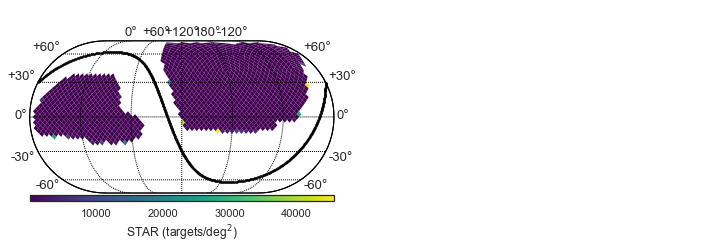

INFO:io.py:1025:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.5/wd_templates_v2.1.fits
INFO:io.py:1025:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.5/wd_templates_v2.1.fits
INFO:mockmaker.py:1385:readmock: Reading the whole DESI footprint with nside = 16.
INFO:mockmaker.py:1396:readmock: Reading /Users/ioannis/work/desi/mocks/mws/wd/v0.0.2/mock_wd.fits
INFO:mockmaker.py:1401:readmock: Assigning healpix pixels with nside = 16
INFO:mockmaker.py:1413:readmock: Trimmed to 189844 WDs in 1269 healpixel(s).


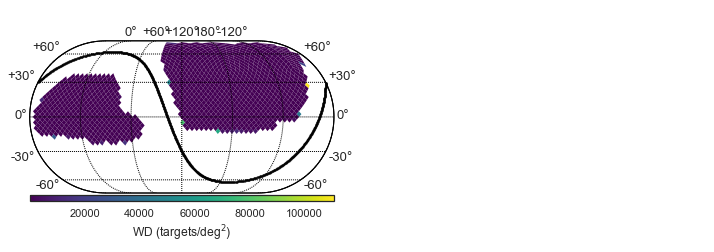

In [8]:
for Maker in (MWS_NEARBYMaker, WDMaker):
    M = Maker()
    data = M.read()
    M.qamock_sky(data, nozhist=True)

#### Sky targets

In [9]:
from desitarget.mock.mockmaker import SKYMaker

INFO:mockmaker.py:627:readmock: Reading the whole DESI footprint with nside = 16.
INFO:mockmaker.py:638:readmock: Reading /Users/ioannis/work/desi/mocks/uniformsky/0.1/uniformsky-2048-0.1.fits
INFO:mockmaker.py:643:readmock: Assigning healpix pixels with nside = 16.
INFO:mockmaker.py:655:readmock: Trimmed to 18335706 SKYs in 1269 healpixel(s).


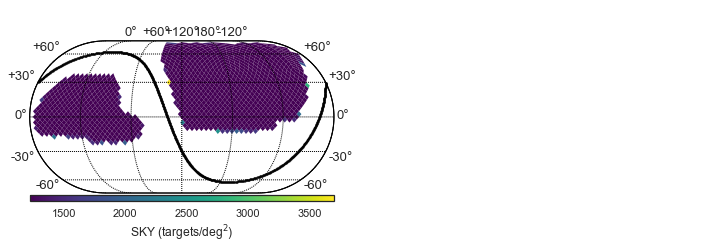

In [10]:
M = SKYMaker()
data = M.read()
M.qamock_sky(data, nozhist=True)